In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
import torch
from torchvision import datasets
from torch.utils.data import random_split, DataLoader

mean = (0.1307,0.1307,0.1307)
std = (0.3081,0.3081,0.3081)

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])

# 1. Load the dataset
dataset = datasets.EuroSAT(root='./data', download=True, transform=transform) # Replace 'transform' with your actual transform

# 2. Define the split sizes
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
val_size = dataset_size - train_size

# 3. Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 4. Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

100%|██████████| 94.3M/94.3M [00:00<00:00, 216MB/s]


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(2592, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1.0)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

In [ ]:
num_epoch = 10
for epoch in range(1, num_epoch + 1):
    train(model, device, train_loader, optimizer, epoch, 100)
    test(model, device, val_loader)
    scheduler.step()

Train Epoch: 1 [0/21600 (0%)]	Loss: 2.304001
Train Epoch: 1 [6400/21600 (30%)]	Loss: 1.821595
Train Epoch: 1 [12800/21600 (59%)]	Loss: 1.366675
Train Epoch: 1 [19200/21600 (89%)]	Loss: 0.880646

Test set: Average loss: 1.0029, Accuracy: 3349/5400 (62%)

Train Epoch: 2 [0/21600 (0%)]	Loss: 1.063125
Train Epoch: 2 [6400/21600 (30%)]	Loss: 1.075153
Train Epoch: 2 [12800/21600 (59%)]	Loss: 1.226072
Train Epoch: 2 [19200/21600 (89%)]	Loss: 1.184327

Test set: Average loss: 0.8219, Accuracy: 3739/5400 (69%)

Train Epoch: 3 [0/21600 (0%)]	Loss: 0.934661
Train Epoch: 3 [6400/21600 (30%)]	Loss: 0.823366
Train Epoch: 3 [12800/21600 (59%)]	Loss: 0.615984
Train Epoch: 3 [19200/21600 (89%)]	Loss: 0.510162

Test set: Average loss: 0.8746, Accuracy: 3631/5400 (67%)

Train Epoch: 4 [0/21600 (0%)]	Loss: 1.017082
Train Epoch: 4 [6400/21600 (30%)]	Loss: 0.388091
Train Epoch: 4 [12800/21600 (59%)]	Loss: 0.410045
Train Epoch: 4 [19200/21600 (89%)]	Loss: 0.404249

Test set: Average loss: 0.5832, Accuracy: 4

In [ ]:
torch.save(model.state_dict(), "eurosat_cnn.pt")

In [ ]:
sample = next(iter(val_loader))
imgs, lbls = sample
len(lbls)

64

In [ ]:
# first 10 predictions
actual_y = lbls[:10].numpy()
print(actual_y)

[3 5 2 3 1 3 5 3 7 6]


In [ ]:
classes = [
    "AnnualCrop",
    "Forest",
    "HerbaceousVegetation",
    "Highway",
    "Industrial",
    "Pasture",
    "PermanentCrop",
    "Residential",
    "River",
    "SeaLake"
]

In [ ]:
imgs, lbls = imgs.to(device), lbls.to(device)
test_output = model(imgs[:10])

pred_y = torch.max(test_output, 1)[1].to('cpu').numpy()
print(f'Predict: {pred_y}')
print(f'Actual : {actual_y}')

print([classes[pred_y[x]] for x in range(10)])
print([classes[actual_y[x]] for x in range(10)])

Predict: [3 5 2 3 1 3 5 6 7 6]
Actual : [3 5 2 3 1 3 5 3 7 6]
['Highway', 'Pasture', 'HerbaceousVegetation', 'Highway', 'Forest', 'Highway', 'Pasture', 'PermanentCrop', 'Residential', 'PermanentCrop']
['Highway', 'Pasture', 'HerbaceousVegetation', 'Highway', 'Forest', 'Highway', 'Pasture', 'Highway', 'Residential', 'PermanentCrop']


In [ ]:
class InverseNormalize(transforms.Normalize):
    def __init__(self, mean, std):
        # The inverse operation for Normalize requires multiplying by std and adding mean.
        # So, we effectively "normalize" with negative mean/std and inverse std.
        # This is equivalent to: (x - (-mean/std)) / (1/std) = (x + mean/std) * std = x*std + mean
        mean = [-m / s for m, s in zip(mean, std)]
        std = [1 / s for s in std]
        super().__init__(mean, std)

inverse_normalize_transform = InverseNormalize(mean=mean, std=std)

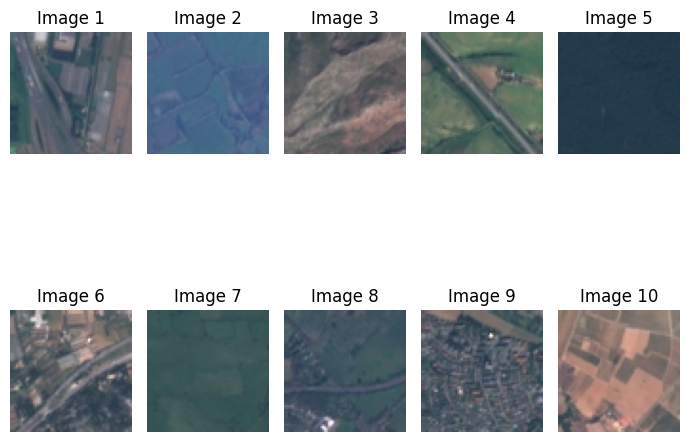

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

num_row = 2
num_col = 5

fig, axes = plt.subplots(num_row, num_col, figsize=(7, 7)) # Adjust figsize as needed
axes = axes.flatten()

for i, img in enumerate(imgs):
    # inverse normalized image
    img = inverse_normalize_transform(img)
    # convert Tensor-image to PIL-image
    to_pil_image_transform = transforms.ToPILImage()
    image = to_pil_image_transform(img)

    if (i< 2*5):
        axes[i].imshow(image) # Use 'gray' colormap for grayscale images
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off') # Turn off axis labels and ticks for cleaner display

plt.tight_layout()
plt.show()